# ---------------------- Imports ----------------------

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
from torchsummary import summary # type: ignore
import onnx # type: ignore
import onnxruntime as ort
from sklearn.metrics import precision_score, recall_score, f1_score

# ---------------------- Dataset Class ----------------------

In [3]:
class SaliencyDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

# ---------------------- Paths & Setup ----------------------

In [4]:
# List of folders
image_dirs = [
    r"/home/user/Shivam/dsr_project/dataset/Co-registered/Simulated dataset/images/RGB",
    r"/home/user/Shivam/dsr_project/dataset/Co-registered/us mil Paper dataset/images/RGB"
]

mask_dirs = [
    r"/home/user/Shivam/dsr_project/dataset/Co-registered/Simulated dataset/saliency_masks",
    r"/home/user/Shivam/dsr_project/dataset/Co-registered/us mil Paper dataset/Saliency_map/RGB"
]

# Collect all images and masks
image_files = []
mask_files = []

for img_dir, msk_dir in zip(image_dirs, mask_dirs):
    imgs = sorted([os.path.join(img_dir, f) for f in os.listdir(img_dir) if f.endswith(".jpg") or f.endswith(".png")])
    msks = sorted([os.path.join(msk_dir, f) for f in os.listdir(msk_dir) if f.endswith(".jpg") or f.endswith(".png")])

    assert len(imgs) == len(msks), f"Mismatch in number of images and masks in {img_dir}"

    image_files.extend(imgs)
    mask_files.extend(msks)

# Split into training and test sets
train_imgs, test_imgs, train_masks, test_masks = train_test_split(image_files, mask_files, test_size=0.2, random_state=42)

# ---------------------- Transforms ----------------------

In [5]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# ---------------- Datasets and DataLoaders ----------------

In [6]:
train_dataset = SaliencyDataset(train_imgs, train_masks, transform=transform)
test_dataset = SaliencyDataset(test_imgs, test_masks, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


# ---------------------- Verify dataset ----------------------

In [7]:
print(f"Total images: {len(image_files)}")
print(f"Total masks: {len(mask_files)}")
print(f"Training images: {len(train_imgs)}, Training masks: {len(train_masks)}")
print(f"Testing images: {len(test_imgs)}, Testing masks: {len(test_masks)}")

Total images: 4851
Total masks: 4851
Training images: 3880, Training masks: 3880
Testing images: 971, Testing masks: 971


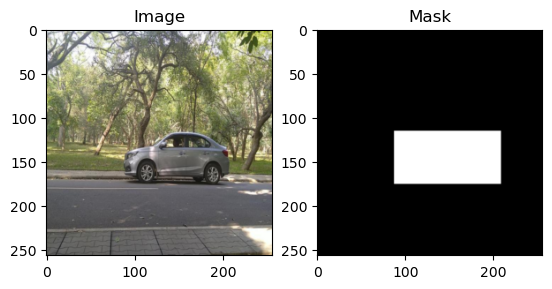

In [8]:
# Visualize some train images and masks
img, msk = train_dataset[2011]
plt.subplot(1,2,1)
plt.imshow(img.permute(1,2,0))
plt.title('Image')
plt.subplot(1,2,2)
plt.imshow(msk.squeeze(), cmap='gray')
plt.title('Mask')
plt.show()


# ---------------------- Defined Model ----------------------

In [2]:
class Saliency_RGB(nn.Module):
    def __init__(self):
        super(Saliency_RGB, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=2, stride=2), nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# ---------------------- Training Setup ----------------------

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Saliency_RGB().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ---------------------- Training Loop ----------------------

In [11]:
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}")

Epoch [1/100], Loss: 0.1941
Epoch [2/100], Loss: 0.1534
Epoch [3/100], Loss: 0.1487
Epoch [4/100], Loss: 0.1410
Epoch [5/100], Loss: 0.1341
Epoch [6/100], Loss: 0.1267
Epoch [7/100], Loss: 0.1230
Epoch [8/100], Loss: 0.1211
Epoch [9/100], Loss: 0.1152
Epoch [10/100], Loss: 0.1137
Epoch [11/100], Loss: 0.1103
Epoch [12/100], Loss: 0.1060
Epoch [13/100], Loss: 0.1023
Epoch [14/100], Loss: 0.1007
Epoch [15/100], Loss: 0.0981
Epoch [16/100], Loss: 0.0946
Epoch [17/100], Loss: 0.0910
Epoch [18/100], Loss: 0.0908
Epoch [19/100], Loss: 0.0889
Epoch [20/100], Loss: 0.0843
Epoch [21/100], Loss: 0.0840
Epoch [22/100], Loss: 0.0830
Epoch [23/100], Loss: 0.0828
Epoch [24/100], Loss: 0.0821
Epoch [25/100], Loss: 0.0812
Epoch [26/100], Loss: 0.0796
Epoch [27/100], Loss: 0.0757
Epoch [28/100], Loss: 0.0757
Epoch [29/100], Loss: 0.0754
Epoch [30/100], Loss: 0.0743
Epoch [31/100], Loss: 0.0725
Epoch [32/100], Loss: 0.0713
Epoch [33/100], Loss: 0.0706
Epoch [34/100], Loss: 0.0700
Epoch [35/100], Loss: 0

# ---------------------- Visualization ----------------------

In [12]:
import random

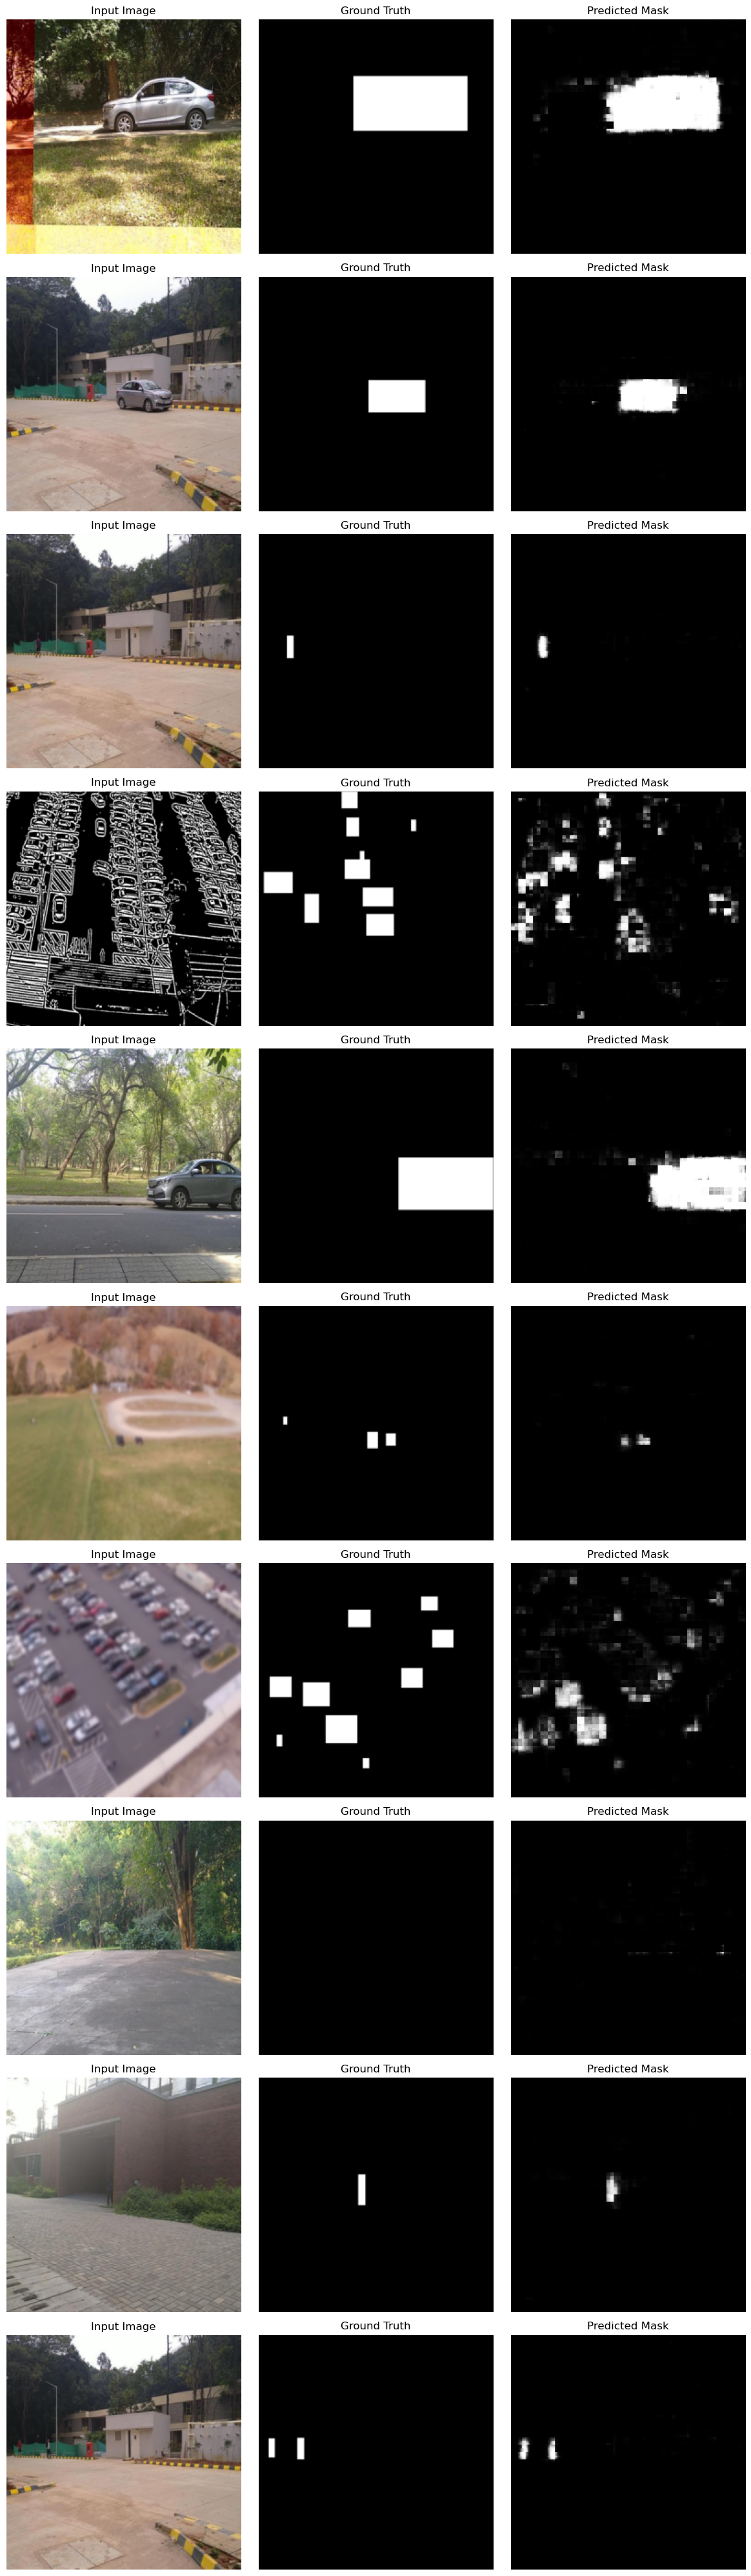

In [30]:
model.eval()
with torch.no_grad():
    # Select 10 random indices
    random_indices = random.sample(range(len(test_dataset)), 10)

    fig, axes = plt.subplots(10, 3, figsize=(12, 40))

    for idx, random_idx in enumerate(random_indices):
        image, mask = test_dataset[random_idx]
        image = image.unsqueeze(0).to(device)
        mask = mask.unsqueeze(0).to(device)

        output = model(image)

        # Move to CPU and prepare for plotting
        image_np = image.squeeze(0).permute(1, 2, 0).cpu().numpy()
        mask_np = mask.squeeze(0).squeeze(0).cpu().numpy()
        output_np = output.squeeze(0).squeeze(0).cpu().numpy()

        axes[idx, 0].imshow(image_np)
        axes[idx, 0].set_title("Input Image")
        axes[idx, 0].axis("off")

        axes[idx, 1].imshow(mask_np, cmap='gray')
        axes[idx, 1].set_title("Ground Truth")
        axes[idx, 1].axis("off")

        axes[idx, 2].imshow(output_np, cmap='gray')
        axes[idx, 2].set_title("Predicted Mask")
        axes[idx, 2].axis("off")

    plt.tight_layout()
    plt.show()

# ---------------------- Saving the model -------------------

In [14]:
torch.save(model.state_dict(), "/home/user/Shivam/dsr_project/Project_files/models/saliency/saliency_model_rgb.pth")
print("Model saved as saliency_model_rgb.pth")

Model saved as saliency_model_rgb.pth


In [15]:
# Instantiate model and load weights
model = Saliency_RGB().to(device)
model.load_state_dict(torch.load("/home/user/Shivam/dsr_project/Project_files/models/saliency/saliency_model_rgb.pth"))
model.eval()

/tmp/ipykernel_25864/1179386131.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/home/user/Shivam/dsr_project/Project_files/models/sali

Saliency_RGB(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
    (3): ReLU()
    (4): ConvTranspose2d(64, 1, kernel_size=(2, 2), stride=(2, 2))
    (5): Sigmoid()
  )
)

# ---------------------- Model Summary ---------------------

In [16]:
# Summary for input size (3 channels, 256x256 image)
summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
         MaxPool2d-3         [-1, 64, 128, 128]               0
            Conv2d-4        [-1, 128, 128, 128]          73,856
              ReLU-5        [-1, 128, 128, 128]               0
         MaxPool2d-6          [-1, 128, 64, 64]               0
            Conv2d-7          [-1, 256, 64, 64]         295,168
              ReLU-8          [-1, 256, 64, 64]               0
         MaxPool2d-9          [-1, 256, 32, 32]               0
  ConvTranspose2d-10          [-1, 128, 64, 64]         131,200
             ReLU-11          [-1, 128, 64, 64]               0
  ConvTranspose2d-12         [-1, 64, 128, 128]          32,832
             ReLU-13         [-1, 64, 128, 128]               0
  ConvTranspose2d-14          [-1, 1, 2

# ------------------ Export Model to ONNX ------------------

In [17]:
dummy_input = torch.randn(1, 3, 256, 256).to(device)  # Example input size

onnx_export_path = "/home/user/Shivam/dsr_project/Project_files/models/saliency/saliency_model_rgb.onnx"

torch.onnx.export(
    model, dummy_input, onnx_export_path,
    input_names=["input"],
    output_names=["output"],
    opset_version=11,
    do_constant_folding=True
)

print(f"Model exported successfully to {onnx_export_path}")

Model exported successfully to /home/user/Shivam/dsr_project/Project_files/models/saliency/saliency_model_rgb.onnx


# ------------------- Verify ONNX Model -------------------

In [18]:
# Load ONNX model
onnx_model = onnx.load(onnx_export_path)
onnx.checker.check_model(onnx_model)
print("ONNX model is valid!")

# Set up inference session
ort_session = ort.InferenceSession(onnx_export_path)

# Test inference on random input
dummy_input_numpy = np.random.randn(1, 3, 256, 256).astype(np.float32)

# Inference
ort_inputs = {ort_session.get_inputs()[0].name: dummy_input_numpy}
ort_outs = ort_session.run(None, ort_inputs)

print(f"ONNX Inference output shape: {ort_outs[0].shape}")

ONNX model is valid!
ONNX Inference output shape: (1, 1, 256, 256)


# ------------ Metrics and application example ------------

In [19]:
def compute_iou(pred_mask, true_mask, threshold=0.5):
    pred_bin = (pred_mask > threshold).astype(np.uint8)
    true_bin = (true_mask > 0.5).astype(np.uint8)

    intersection = np.logical_and(pred_bin, true_bin).sum()
    union = np.logical_or(pred_bin, true_bin).sum()

    if union == 0:  # Avoid division by zero
        return float(intersection == 0)
    return intersection / union

ious = []

model.eval()
with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)

        for i in range(images.size(0)):
            pred = outputs[i][0].cpu().numpy()
            true = masks[i][0].cpu().numpy()
            iou = compute_iou(pred, true)
            ious.append(iou)

mean_iou = np.mean(ious)
print(f"Mean IoU on test set: {mean_iou:.4f}")

Mean IoU on test set: 0.5766


In [20]:
def compute_min_salient_fraction(dataloader):
    min_fraction = float('inf')
    valid_count = 0

    for _, masks in dataloader:
        for mask in masks:
            mask_np = mask[0].numpy()
            binary_mask = (mask_np > 0.5).astype(np.uint8)
            total_pixels = binary_mask.size
            salient_pixels = np.sum(binary_mask)

            if salient_pixels == 0:
                continue  # Skip completely black masks

            frac = salient_pixels / total_pixels
            min_fraction = min(min_fraction, frac)
            valid_count += 1

    if valid_count == 0:
        raise ValueError("No non-empty masks found in dataset.")

    return min_fraction

threshold_fraction = compute_min_salient_fraction(test_loader)
print(f"Data-driven Saliency Threshold (non-empty GT): {threshold_fraction:.4f}")

Data-driven Saliency Threshold (non-empty GT): 0.0010


In [21]:
def is_object_present(saliency_map, threshold=0.5, pixel_fraction=0.001):
    binary_mask = saliency_map > threshold
    active_pixels = np.sum(binary_mask)
    total_pixels = binary_mask.size
    return active_pixels / total_pixels > pixel_fraction

In [22]:
# Object detection recall based on saliency
y_true = []
y_pred = []

with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)

        for i in range(images.size(0)):
            pred = outputs[i][0].cpu().numpy()
            true = masks[i][0].cpu().numpy()

            # GT: is there any object in the mask?
            object_in_gt = is_object_present(true, threshold=0.5, pixel_fraction=0.001)
            object_in_pred = is_object_present(pred, threshold=0.5, pixel_fraction=0.001)

            y_true.append(object_in_gt)
            y_pred.append(object_in_pred)

# Compute Recall
true_positive = sum([t and p for t, p in zip(y_true, y_pred)])
false_negative = sum([t and not p for t, p in zip(y_true, y_pred)])
recall = true_positive / (true_positive + false_negative + 1e-6)  # avoid division by zero
print(f"Object Presence Recall: {recall:.4f}")


Object Presence Recall: 0.9728


In [23]:
y_true, y_pred = [], []

with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)

        outputs = model(images)
        pred = outputs[0][0].cpu().numpy()
        true = masks[0][0].cpu().numpy()

        pred_bin = (pred > 0.5).astype(np.uint8)
        true_bin = (true > 0.5).astype(np.uint8)

        pred_fraction = np.sum(pred_bin) / pred_bin.size
        true_fraction = np.sum(true_bin) / true_bin.size

        object_pred = pred_fraction > threshold_fraction
        object_true = true_fraction > threshold_fraction

        y_true.append(object_true)
        y_pred.append(object_pred)

# Calculate metrics
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"\nPrecision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")


Precision: 0.9913
Recall:    0.9828
F1-score:  0.9870


Predicted: Object Present
Ground Truth: Object Present


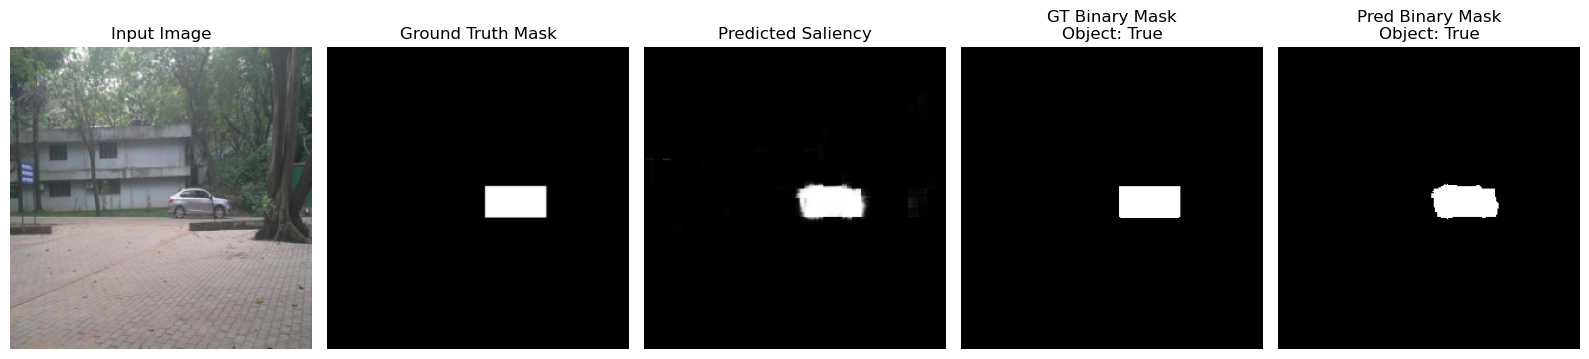

Predicted: Object Present
Ground Truth: Object Present


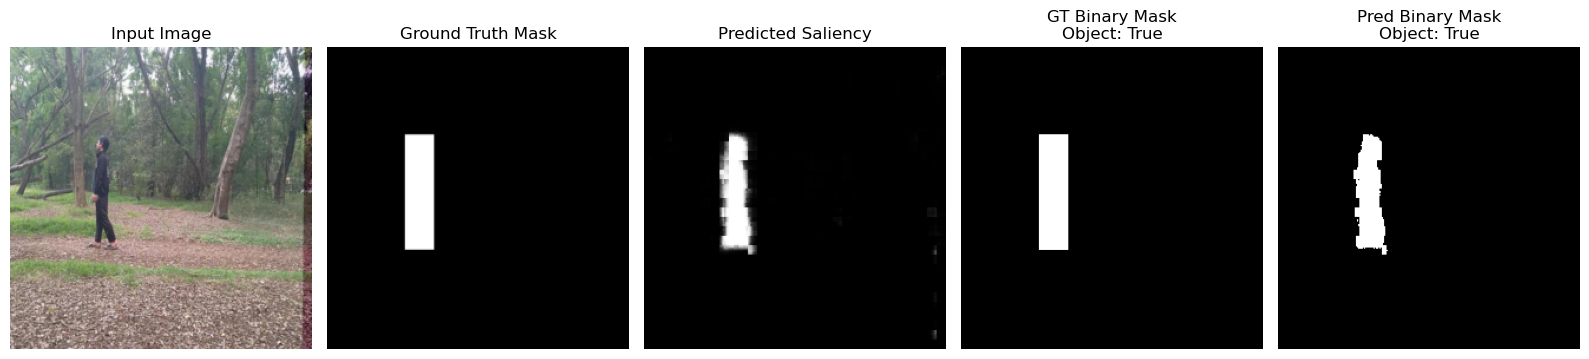

Predicted: Object Present
Ground Truth: Object Present


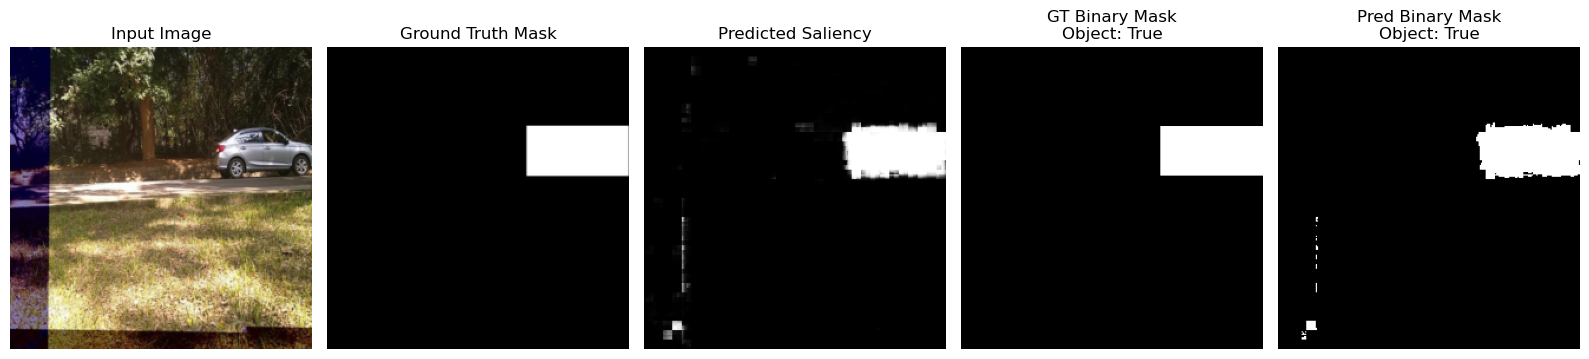

Predicted: Object Present
Ground Truth: Object Present


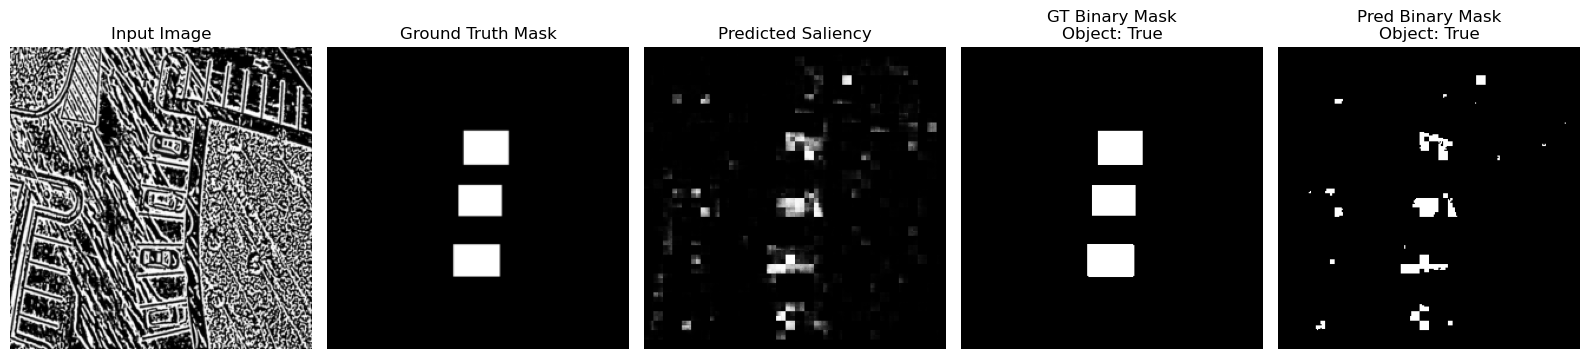

Predicted: Object Present
Ground Truth: Object Present


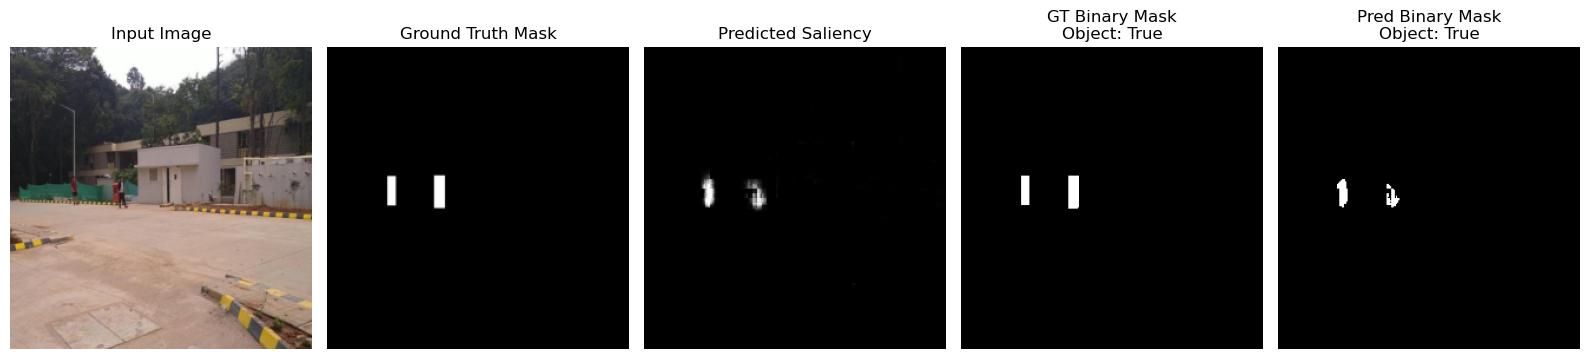

Predicted: Object Present
Ground Truth: Object Present


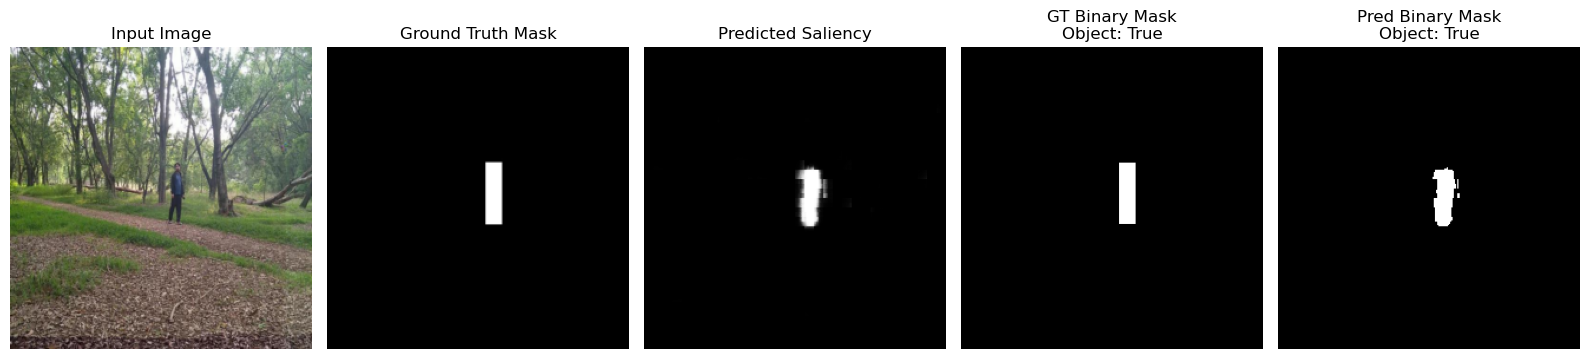

Predicted: Object Present
Ground Truth: Object Present


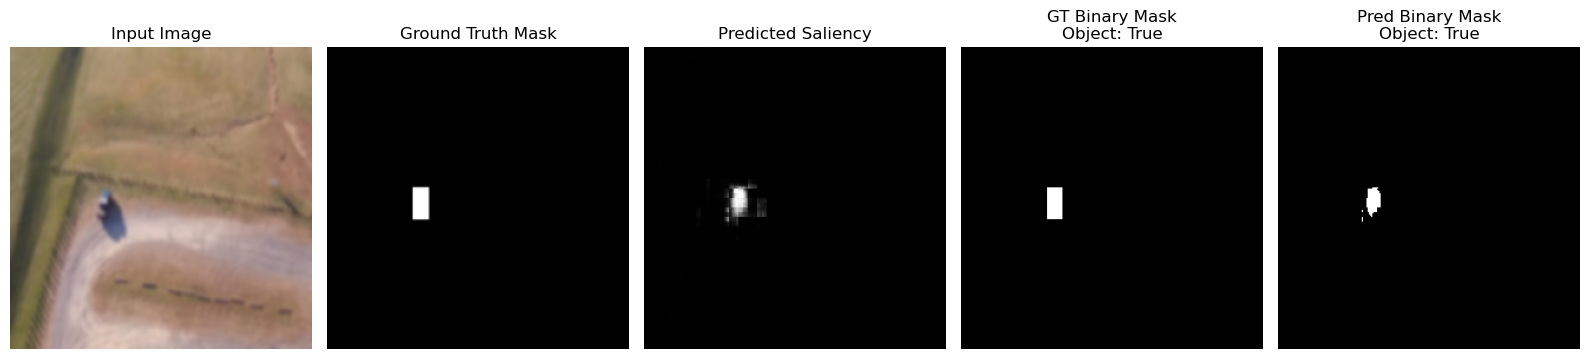

Predicted: Object Present
Ground Truth: Object Present


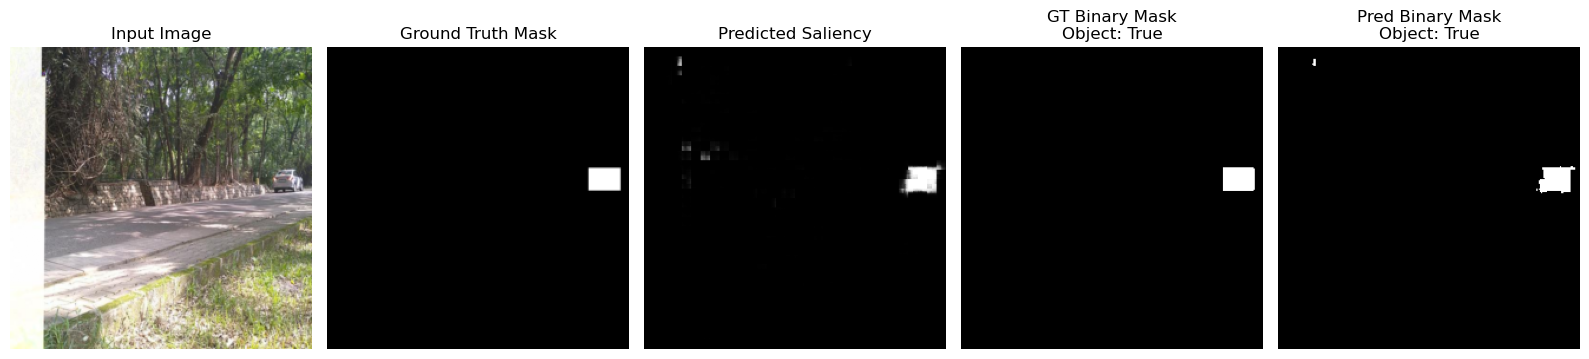

Predicted: Object Present
Ground Truth: Object Present


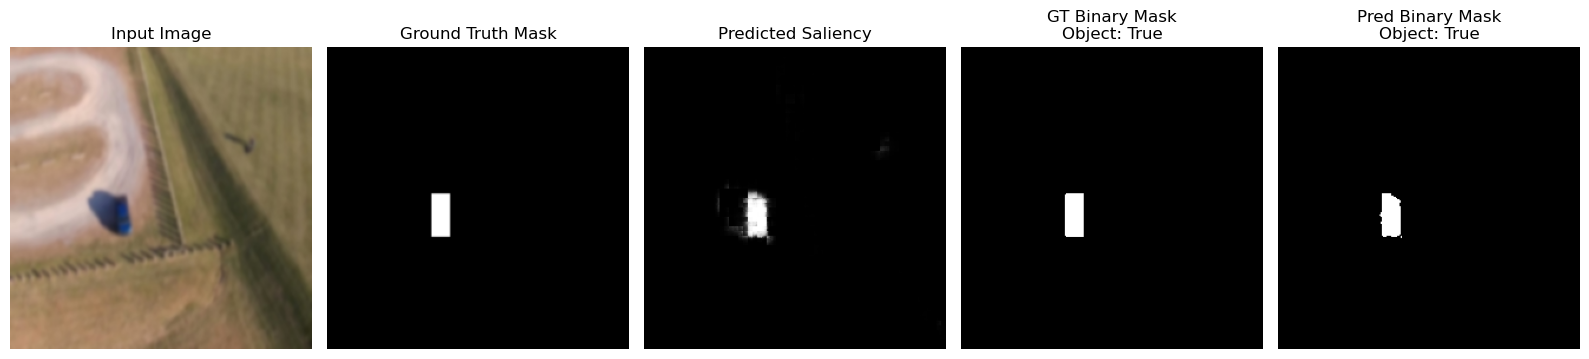

Predicted: Object Present
Ground Truth: Object Present


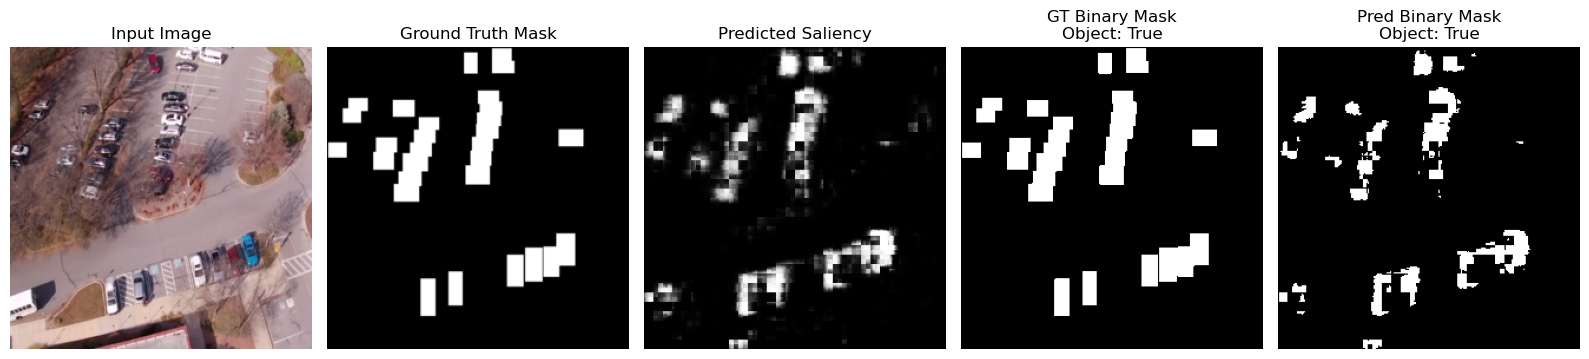

In [28]:
def visualize_detection_logic(model, dataloader, threshold=0.5, area_fraction=0.001, num_samples=10):
    model.eval()
    with torch.no_grad():
        # Randomly select indices
        indices = random.sample(range(len(dataloader.dataset)), num_samples)
        
        for idx in indices:
            # Get the image and its corresponding mask for the selected index
            image, mask = dataloader.dataset[idx]
            image = image.unsqueeze(0).to(device)  # Add batch dimension
            mask = mask.unsqueeze(0).to(device)    # Add batch dimension

            outputs = model(image)
            pred = outputs[0][0].cpu().numpy()  # Predicted saliency
            gt = mask[0][0].cpu().numpy()       # Ground truth saliency
            image = image[0].permute(1, 2, 0).cpu().numpy()

            # Thresholding
            pred_bin = pred > threshold
            gt_bin = gt > threshold

            # Object presence based on saliency area
            pred_present = (np.sum(pred_bin) / pred_bin.size) > area_fraction
            gt_present = (np.sum(gt_bin) / gt_bin.size) > area_fraction

            print(f"Predicted: {'Object Present' if pred_present else 'No Object'}")
            print(f"Ground Truth: {'Object Present' if gt_present else 'No Object'}")

            # Visualization
            fig, axs = plt.subplots(1, 5, figsize=(16, 4))
            axs[0].imshow(image)
            axs[0].set_title("Input Image")
            axs[1].imshow(gt, cmap="gray")
            axs[1].set_title("Ground Truth Mask")
            axs[2].imshow(pred, cmap="gray")
            axs[2].set_title("Predicted Saliency")
            axs[3].imshow(gt_bin, cmap="gray")
            axs[3].set_title(f"GT Binary Mask\nObject: {gt_present}")
            axs[4].imshow(pred_bin, cmap="gray")
            axs[4].set_title(f"Pred Binary Mask\nObject: {pred_present}")

            for ax in axs:
                ax.axis('off')
            plt.tight_layout()
            plt.show()

# Example usage
visualize_detection_logic(model, test_loader, threshold=0.5, area_fraction=0.001, num_samples=10)

Predicted: Object Present
Ground Truth: Object Present


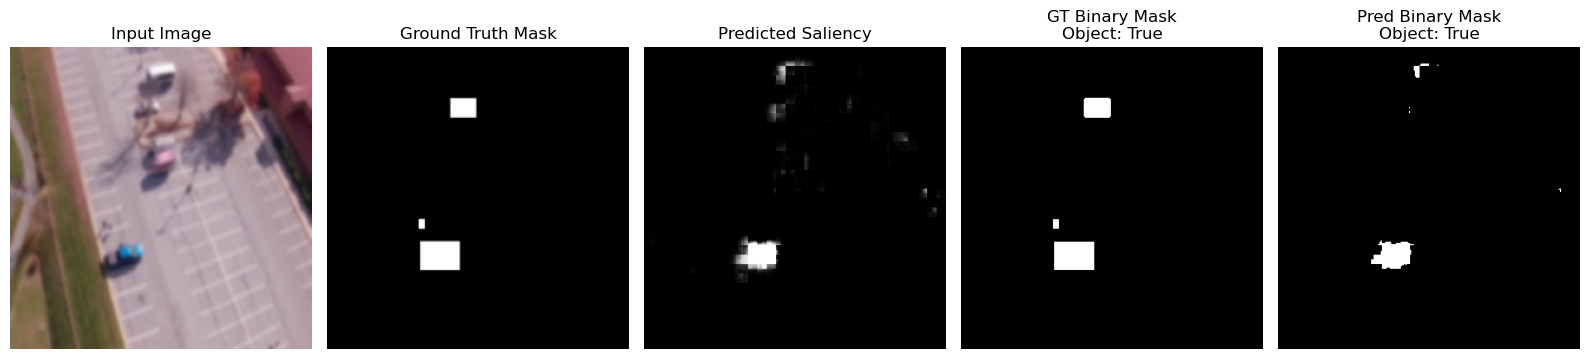

In [25]:
def visualize_detection_logic(model, dataloader, threshold=0.5, area_fraction=0.001):
    model.eval()
    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            pred = outputs[0][0].cpu().numpy()  # Predicted saliency
            gt = masks[0][0].cpu().numpy()      # Ground truth saliency
            image = images[0].permute(1, 2, 0).cpu().numpy()

            # Thresholding
            pred_bin = pred > threshold
            gt_bin = gt > threshold

            # Object presence based on saliency area
            pred_present = (np.sum(pred_bin) / pred_bin.size) > area_fraction
            gt_present = (np.sum(gt_bin) / gt_bin.size) > area_fraction

            print(f"Predicted: {'Object Present' if pred_present else 'No Object'}")
            print(f"Ground Truth: {'Object Present' if gt_present else 'No Object'}")

            # Visualization
            fig, axs = plt.subplots(1, 5, figsize=(16, 4))
            axs[0].imshow(image)
            axs[0].set_title("Input Image")
            axs[1].imshow(gt, cmap="gray")
            axs[1].set_title("Ground Truth Mask")
            axs[2].imshow(pred, cmap="gray")
            axs[2].set_title("Predicted Saliency")
            axs[3].imshow(gt_bin, cmap="gray")
            axs[3].set_title(f"GT Binary Mask\nObject: {gt_present}")
            axs[4].imshow(pred_bin, cmap="gray")
            axs[4].set_title(f"Pred Binary Mask\nObject: {pred_present}")

            for ax in axs:
                ax.axis('off')
            plt.tight_layout()
            plt.show()
            break  # Show one sample only

# Example usage
visualize_detection_logic(model, test_loader, threshold=0.5, area_fraction=0.001)

# ------------------ Export Model to .PT ------------------

In [4]:
# Instantiate model and load weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Saliency_RGB().to(device)
model.load_state_dict(torch.load("/home/user/Shivam/dsr_project/Project_files/models/saliency/saliency_model_rgb.pth"))
model.eval()

/tmp/ipykernel_329557/954330554.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/home/user/Shivam/dsr_project/Project_files/models/sali

Saliency_RGB(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
    (3): ReLU()
    (4): ConvTranspose2d(64, 1, kernel_size=(2, 2), stride=(2, 2))
    (5): Sigmoid()
  )
)

In [5]:
model = model.to('cpu')

In [6]:
dummy_input = torch.randn(1, 3, 256, 256)
# Trace the model to TorchScript
scripted_model = torch.jit.trace(model, dummy_input)

In [7]:
# Save the TorchScript model
output_path = "/home/user/Shivam/dsr_project/Project_files/models/saliency/saliency_model_rgb.pt"
scripted_model.save(output_path)

print(f"TorchScript model saved to {output_path}")

TorchScript model saved to /home/user/Shivam/dsr_project/Project_files/models/saliency/saliency_model_rgb.pt
